## Libs

In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier 

In [2]:
def print_metrics(true, pred):
    # calculate metrics & create visualizations
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"accuracy: {accuracy_score(true, pred):.3f}")
    print(f"precision: {precision_score(true, pred):.3f}")
    print(f"recall: {recall_score(true, pred):.3f}")
    print(f"f1 (avg=binary): {f1_score(true, pred, average='binary'):.3f}")
    print(f"f1 (avg=macro): {f1_score(true, pred, average='macro'):.3f}")

## Read data

In [3]:
# merged both datasets to apply fixes for both, splitting again
df = pd.read_csv("interdata/df_fixed_01.csv")

## Feature Engineering

In [4]:
# to date 
df['repair_date'] = pd.to_datetime(df['repair_date'])
df['breakdown_date'] = pd.to_datetime(df['breakdown_date'])

# normalize some time features by "age"
df['reg_date'] = pd.to_datetime(df['Reg_year'].astype(str) + '-01-01')
df['car_age_yr'] = (df['breakdown_date'] - df['reg_date']) /  pd.Timedelta(days=365.25)
df['mileage_yr'] = df['Runned_Miles'] / df['car_age_yr']

# Replace missing values in 'repair_date' with values from 'breakdown_date'
df['repair_date'] = df['repair_date'].fillna(df['breakdown_date'])
df['repair_weekday'] = df['repair_date'].dt.day_name()

# cross prod
df['repair_cost_Price'] = df.repair_cost * df.Price
df['repair_hours_Price'] = df.repair_hours * df.Price

In [6]:
# deal with datetime columns
df['repair_date'] = (df['repair_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
df['breakdown_date'] = (df['breakdown_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)

In [7]:
# select columns
df = df[[
       'ID','Maker', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size',
       'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'issue', 'issue_id',
       'breakdown_date', 
       'repair_complexity', 'repair_cost', 'repair_hours', 'repair_date', 'repair_cost_Price',
       'repair_hours_Price', 
       'car_age_yr', 'mileage_yr', 'repair_weekday', 'Label'
       ]]
df.head()

,ID,Maker,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,issue_id,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,repair_cost_Price,repair_hours_Price,car_age_yr,mileage_yr,repair_weekday,Label
0,16130,Ford,Blue,2017,Hatchback,1636,1.2,Manual,Petrol,7490,5,5,Tyre Alignment,0,17636,1,10.749000,0.500000,17636,8.051001e+04,3.745000e+03,1.284052,1274.091684,Sunday,0.0
1,16131,Ford,Blue,2016,SUV,9820,2.0,Manual,Diesel,23995,5,5,Radiator Leaking,0,17671,1,519.900000,2.000000,17671,1.247500e+07,4.799000e+04,2.381930,4122.706897,Sunday,0.0
2,16132,Honda,Grey,2012,SUV,38500,2.2,Automatic,Diesel,11750,5,5,Sensor Malfunction,0,17769,1,3059.099027,2172.572165,17772,3.594441e+07,2.552772e+07,6.650240,5789.265130,Wednesday,1.0
3,16133,Ford,Silver,2012,SUV,43445,2.0,Manual,Diesel,9999,5,5,Gear Box Issue,0,17657,1,571.012064,437.382279,17676,5.709550e+06,4.373385e+06,6.343600,6848.634549,Friday,1.0
4,16134,Honda,Grey,2018,SUV,7491,1.6,Manual,Diesel,21999,5,5,Alternator Failing,0,17687,1,479.980000,2.000000,17687,1.055908e+07,4.399800e+04,0.424367,17652.179032,Tuesday,0.0


In [8]:
df_val    = df[df['Label'].isna()]
df_train  = df[df['Label'].notna()]

print("Dimensions of the df_test:", df_val.shape)
print("Dimensions of the df_train:", df_train.shape)

Dimensions of the df_test: (16129, 25)
Dimensions of the df_train: (37637, 25)
Dimensions of the df_test: (16129, 25)
Dimensions of the df_train: (37637, 25)


In [9]:
X = df_train.drop(columns=["Label"])
y = df_train["Label"]
# X_test = df_val.drop(columns=["Label"])
# y_test = df_val["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Pipelines

### baseline: logistic regression

In [10]:
# Assign the numerical and categorical (nominal) columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

#numerical_features = ['Age', 'Flight distance'] # for tree-based methods
numerical_features = [col for col in X.columns.tolist() if col not in categorical_features]  # for linear methods
# try: numerical_features.remove("ID")
# except: pass

print(categorical_features)
print(numerical_features)

['Maker', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type', 'issue', 'repair_weekday']
['ID', 'Reg_year', 'Runned_Miles', 'Engin_size', 'Price', 'Seat_num', 'Door_num', 'issue_id', 'breakdown_date', 'repair_complexity', 'repair_cost', 'repair_hours', 'repair_date', 'repair_cost_Price', 'repair_hours_Price', 'car_age_yr', 'mileage_yr']
['Maker', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type', 'issue', 'repair_weekday']
['ID', 'Reg_year', 'Runned_Miles', 'Engin_size', 'Price', 'Seat_num', 'Door_num', 'issue_id', 'breakdown_date', 'repair_complexity', 'repair_cost', 'repair_hours', 'repair_date', 'repair_cost_Price', 'repair_hours_Price', 'car_age_yr', 'mileage_yr']


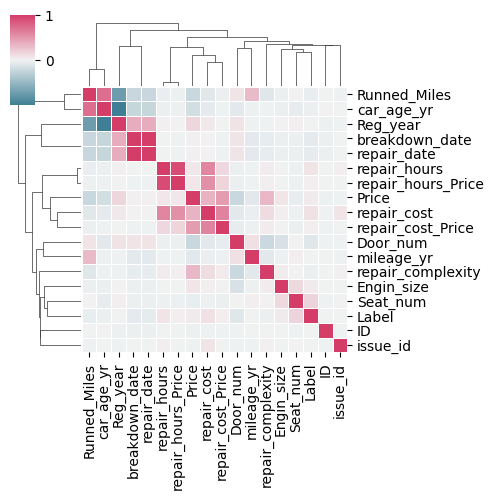

In [11]:
import seaborn as sns
corr = df_train[numerical_features + ["Label"]].corr()
clustergrid = sns.clustermap(
    corr,
    cmap=sns.diverging_palette(222, 0, as_cmap=True),
    figsize=(5, 5),
    linewidths=0.5
)

In [12]:
# trying out oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=42,
)
X_train, y_train = ros.fit_resample(X_train, y_train)
# did not improve... actually made worse

### XGBClassifier

In [13]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('clf', XGBClassifier(random_state=42, learning_rate = 0.03203))])
pipe

# estimators = [
#     ('encoder', TargetEncoder()),
#     ('clf', XGBClassifier(
#         random_state=42, 
#         learning_rate = 0.03203
#     ))
# ]
# pipe = Pipeline(steps=estimators)
# pipe


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ID', 'Reg_year',
                                                   'Runned_Miles', 'Engin_size',
                                                   'Price', 'Seat_num',
                                                   'Door_num', 'issue_id',
                                                   'breakdown_date',
                                                   'repair_complexity',
                                                   'repair_cost',
                                                   'repair_hours',
                                                   'repair_date',
                                                   'repair_cost_Price',
                                                   'repair_hours_Price',
                                                   'car_age_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03203, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [14]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    "clf__max_depth": Integer(5, 100),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0.0, 1000),
    "clf__reg_lambda": Real(0.0, 1000),
    "clf__gamma": Real(1.5, 20)
}

xgb_fit_params = {
    # trying out some fit params (for early stopping, but unsure if its working...)
    "early_stopping_rounds": 10,
    "eval_metric": "f1_macro",
    "eval_set": [[X_test, y_test]],
}

opt = BayesSearchCV(
    pipe,
    search_space,
    cv = 5,
    n_iter = 128,
    scoring = "f1_macro",
    random_state = 442,
    fit_params = xgb_fit_params,
    verbose = False,
)

In [15]:
opt.fit(X_train, y_train)
print(f"best score: {opt.best_score_}")

best score: 0.9681983033868555
best score: 0.9681983033868555


In [16]:
# get best model
best_model = opt.best_estimator_
best_model
print(best_model.get_params())

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['ID', 'Reg_year', 'Runned_Miles',
                                  'Engin_size', 'Price', 'Seat_num', 'Door_num',
                                  'issue_id', 'breakdown_date',
                                  'repair_complexity', 'repair_cost',
                                  'repair_hours', 'repair_date',
                                  'repair_cost_Price', 'repair_hours_Price',
                                  'car_age_yr', 'mileage_yr']),
                                ('cat', TargetEncoder(),
                                 ['Maker', 'Color', 'Bodytype', 'Gearbox',
                                  'Fuel_type', 'issue', 'repair_weekday'])])), ('clf', XGBClassifier(base_score=None, booster=None, callbacks=None,

Best Threshold: 0.32323232323232326
Best Threshold: 0.32323232323232326


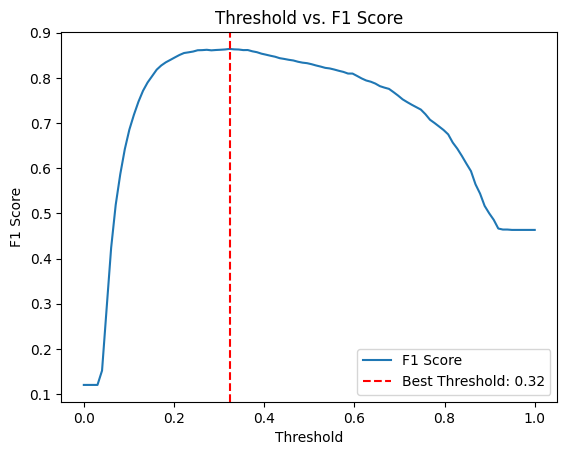

In [17]:
# Predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]  # X_test is your test/validation data

# True labels
y_true = y_test  # y_test is your test/validation labels

# Range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Evaluate F1-score for each threshold
from sklearn.metrics import f1_score
f1_scores = [f1_score(y_true, y_probs >= t, average='macro') for t in thresholds]

# Best threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

import matplotlib.pyplot as plt

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs. F1 Score')
plt.axvline(
    best_threshold, color='r', linestyle='--',
    label=f'Best Threshold: {best_threshold:.2f}'
)
plt.legend()
plt.show()

In [23]:
y_validation_proba = best_model.predict_proba(X_test)[:,1]
# y_validation_proba
y_validation_bin =  (y_validation_proba >= best_threshold).astype(int)
print_metrics(y_test, y_validation_bin)

accuracy: 0.925
precision: 0.661
recall: 0.929
f1 (avg=binary): 0.773
f1 (avg=macro): 0.864
accuracy: 0.925
precision: 0.661
recall: 0.929
f1 (avg=binary): 0.773
f1 (avg=macro): 0.864


Feature Importance


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

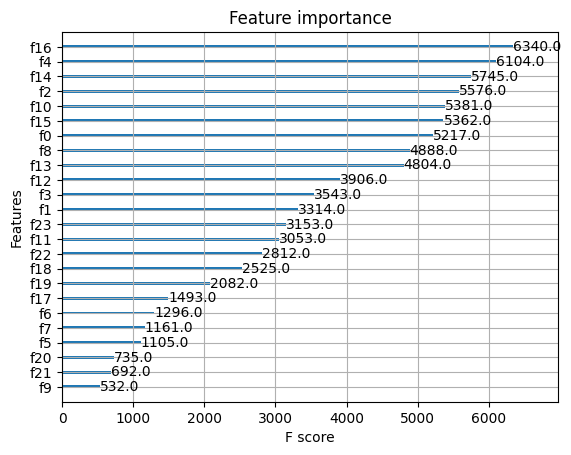

In [19]:
xgb.plot_importance(best_model._final_estimator)

## Export validation

In [20]:
## export validation set 

# export predictionsdf_val
try: df_val = df_val.drop(columns='Label')
except: pass 

y_validation_proba = best_model.predict_proba(df_val)[:,1]
df_val['Label'] =  (y_validation_proba >= best_threshold).astype(int)
df_val.head()

# Get the current date
from datetime import datetime
date_str = datetime.now().strftime('%Y%m%d')
filename = f"./outdata/predicted_{date_str}_res.csv"

cols_to_export = ['ID', 'Label']
df_export = df_val[cols_to_export]
df_export.to_csv(filename, index=False)

In [21]:
# save final model to disk
import pickle

model_pkl_file = f"interdata/xgb_classifier_model{date_str}.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(best_model, file)

In [22]:
datetime.now()

datetime.datetime(2024, 11, 18, 22, 55, 46, 92888)